# Car-free COVID-19

The COVID-19 pandemic and associated shelter-at-home orders
have caused huge declines in people moving around Los Angeles.

Let's take a look at loop detector data from before and after
Los Angeles' "Safer at Home" order and see which streets saw
the biggest declines in traffic.

First, we make some necessary imports:

In [1]:
import geopandas
import numpy
import pandas

## Aggregating the loop detector data

The loop detector data give very detailed time resolution,
so the first thing we want to do is to aggregate it to total
daily values.

Let's read in data from Tuesday March 10 and Tuesday March 30 (three weeks later).
For both of those days, we sum all the data for each detector.

In [2]:
before = pandas.read_parquet("det_data_20200311.parquet")
after = pandas.read_parquet("det_data_20200401.parquet")

In [3]:
before_volume = before.groupby("ID").agg({
    "VOL": "sum",
    "LAT": "first",
    "LON": "first",
    "DET_TYPE": "first",
    "ANGLE": "first",
    "MOVEMENT": "first",
    "LAT_INT": "first",
    "LON_INT": "first",
}).rename(columns={
    "VOL": "before_volume",
    "LAT": "lat",
    "LON": "lon",
    "DET_TYPE": "detector_type",
    "ANGLE": "angle",
    "MOVEMENT": "movement",
    "LAT_INT": "lat_int",
    "LON_INT": "lon_int",
})
before_volume = before_volume.set_index(before_volume.index.astype("int64"))

In [4]:
after_volume = after.groupby("ID").agg({
    "VOL": "sum",
    "LAT": "first",
    "LON": "first",
    "DET_TYPE": "first",
    "ANGLE": "first",
    "MOVEMENT": "first",
    "LAT_INT": "first",
    "LON_INT": "first",
}).rename(columns={
    "VOL": "after_volume",
    "LAT": "lat",
    "LON": "lon",
    "DET_TYPE": "detector_type",
    "ANGLE": "angle",
    "MOVEMENT": "movement",
    "LAT_INT": "lat_int",
    "LON_INT": "lon_int",
})

We combine the before/after counts indo a single dataset:

In [5]:
volume = before_volume.assign(
    before_volume=before_volume.before_volume.astype("int32"),
    after_volume=after_volume.after_volume.astype("int32"),
).reset_index()

In [6]:
volume = geopandas.GeoDataFrame(
    volume,
    geometry=geopandas.points_from_xy(volume.lon, volume.lat)
).drop(columns=["lon", "lat"])

We can checkpoint this aggregated dataset as a GeoJSON to avoid having to recompute it every time:

In [7]:
volume.to_file("covid-loop-counts.geojson", driver="GeoJSON")

Okay, now we have before/after counts for each loop detector.
Let's join that to city streets and see which ones have had the biggest change.

## Loading street data

In [8]:
# Load streets and loop count aggregates
streets = geopandas.read_file("streets.geojson")
loops = geopandas.read_file("covid-loop-counts.geojson")

The streets centerlines dataset is mostly at the block-level,
but we are more interested in corridor-level analysis.
Let's aggregate that up to the street level:

In [9]:
# Aggregate the block-level streets into corridors
corridors = streets[
    ["STNAME", "STNUM", "geometry", "Street_Designation"]
].dissolve("STNUM", as_index=False, aggfunc=lambda x: x.value_counts().index[0])

In [10]:
# Filter the corridors to be named non-local streets longer than one half mile
# to avoid assigning loop count aggregates to the small spurs.
corridors = corridors[
    ~corridors.STNAME.isna() &
    (corridors.STNAME != "") &
    (corridors.to_crs(epsg=2229).geometry.length > 5280./2.) &
    ~corridors.Street_Designation.str.contains("Local Street") &
    ~corridors.Street_Designation.str.contains("Unidentified")
]

We want to associate loop detectors with a specific street,
so we create a 250 ft buffer around each corridor to allow us
to test if a detector falls within it. This will give us
candidate corridors for each detector, which we will attempt
to whittle down to one corridor later.

In [11]:
corridors = corridors.assign(
    buffered=corridors.to_crs(epsg=2229).buffer(250).to_crs(epsg=4326)
)

We also create a geometry column in the loops dataset to hold the intersection location:

In [12]:
loops = loops.assign(
    intersection_geometry=geopandas.points_from_xy(loops.lon_int, loops.lat_int)
)

## Joining the data

Joining the loop detectors to the streets is a very tricky operation.
We want to assign each loop count to a particular corridor, but by their nature,
the detectors are installed at/near intersections,
so it can be difficult to determine which street they belong to.

We go about this in two passes:
1. First, we find the all the detectors that fall within each of the street buffers that was created above. We expect many detectors to fall within more than one buffer, since they are near intersections.
1. Second, we decide which street to assign based on the "ANGLE" property of the detector data. We measure the angle of the detector-intersection pair, and compare that with each candidate  detector-street centroid pair. The street that has the closest orientation is assigned the detector. An earlier version of this just chose the closest street to the detector, but this mis-assigned more detectors to small spur streets.

In [13]:
joined = geopandas.sjoin(
    corridors.set_geometry("buffered"),
    loops,
    op="contains",
).set_geometry("geometry")

In [14]:
joined = joined.merge(
    loops.rename_geometry("loop_geometry")[["ID", "loop_geometry"]],
    how="left",
    on="ID",
)

In [15]:
def compute_loop_angle(df):
    """
    Computes the dot product between the detector-intersection vector
    and the detector-street cetroid vector. The ones with the closest
    value to 1 have the most similar orientations.
    This might fail for non-rectilinear streets.
    """
    street_centroid = df.geometry.centroid
    loop_geometry = geopandas.GeoSeries(df.loop_geometry)
    intersection_geometry = geopandas.GeoSeries(df.intersection_geometry)
    dx1 = street_centroid.x - loop_geometry.x
    dy1 = street_centroid.y - loop_geometry.y
    norm1 = numpy.sqrt(dx1*dx1 + dy1*dy1)
    dx2 = intersection_geometry.x - loop_geometry.x
    dy2 = intersection_geometry.y - loop_geometry.y
    norm2 = numpy.sqrt(dx2*dx2+dy2*dy2)
    return numpy.abs((dx1*dx2 + dy1*dy2)/norm1/norm2)

In [16]:
joined = joined.assign(
    dot = compute_loop_angle(joined)
).sort_values("dot", ascending=False).drop_duplicates(subset=["ID"])

## Computing corridor changes

Now that we have joined the loop detector totals to the streets,
let's come up with corridor-level summaries.
We compute the mean before/after volumes for the detectors on each corridor
as a representative number for the change in traffic on the street.
Note that we could also look at the total volume change on each street,
but this would heavily weight long arterial corridors like Santa Monical Boulevard or Sepulveda,
and might not represent changes on more local corridors. 

In [17]:
vols = joined.groupby("STNUM").agg({
    "Street_Designation": "first",
    "STNAME": "first",
    "geometry": "first",
    "before_volume": "mean",
    "after_volume": "mean",
})

In [18]:
vols = geopandas.GeoDataFrame(vols, geometry="geometry", crs="EPSG:4326")
vols = vols.assign(
    delta_volume=vols.after_volume-vols.before_volume,
    percent_change=100.*(vols.after_volume-vols.before_volume)/vols.before_volume,
).sort_values("delta_volume", ascending=True)

## Results

Let's take a look at the corridors which had the biggest drop in loop detector counts:

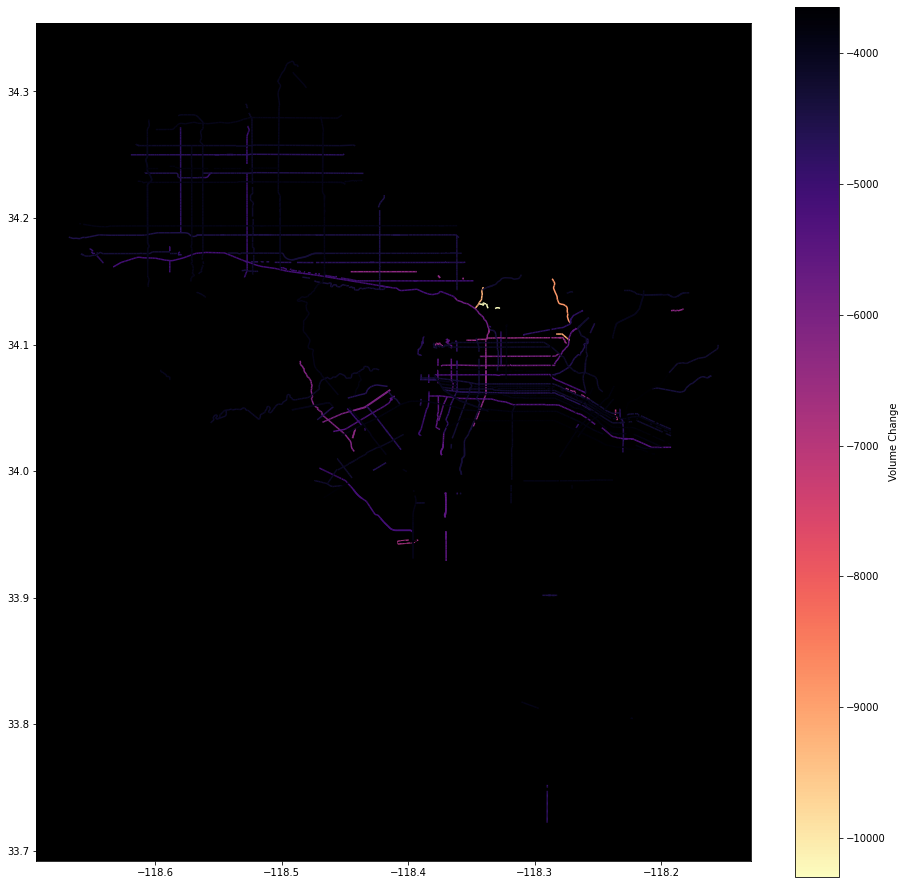

In [19]:
TOP_N = 100

vols.head(TOP_N).plot(
    figsize=(16,16),
    column="delta_volume",
    cmap="magma_r",
    legend=True,
    legend_kwds={"label": "Volume Change"},
).set_facecolor('k')

In [20]:
pandas.options.display.max_rows = TOP_N
vols.set_index("STNAME").head(TOP_N)

,Street_Designation,geometry,before_volume,after_volume,delta_volume,percent_change
STNAME,,,,,,
LAKE HOLLYWOOD,Collector,"MULTILINESTRING ((-118.34337 34.13206, -118.34...",12900.000000,2601.000000,-10299.000000,-79.837209
BARHAM,Avenue I,"MULTILINESTRING ((-118.34453 34.13181, -118.34...",12546.230769,3319.923077,-9226.307692,-73.538482
TRACY,Collector,"MULTILINESTRING ((-118.27337 34.10406, -118.27...",16194.000000,7089.000000,-9105.000000,-56.224528
CRYSTAL SPRINGS,Private,"MULTILINESTRING ((-118.28460 34.14689, -118.28...",17444.500000,8598.000000,-8846.500000,-50.712259
HEWITT,Collector,"MULTILINESTRING ((-118.23539 34.04359, -118.23...",10080.500000,3061.500000,-7019.000000,-69.629483
WORLD,Private,"MULTILINESTRING ((-118.39207 33.94557, -118.39...",9116.666667,2414.250000,-6702.416667,-73.518282
FRANKLIN,Modified Avenue III,"MULTILINESTRING ((-118.29948 34.10539, -118.30...",11139.220000,4697.520000,-6441.700000,-57.829004
MIRAMAR,Collector,"MULTILINESTRING ((-118.25939 34.05823, -118.25...",15935.000000,9512.000000,-6423.000000,-40.307499
RIVERSIDE,Avenue I,"MULTILINESTRING ((-118.37482 34.15277, -118.37...",9256.583333,2936.500000,-6320.083333,-68.276632
